In [25]:
import numpy as np
import pandas as pd
import os
import sys
import scipy.io as sio
from os import listdir
from os.path import isfile, join, exists
from IPython.core.debugger import set_trace
import copy
from tqdm import tqdm
import nibabel as nib

import matplotlib.pyplot as plt
import cortex

In [31]:
homedir = '/lab_data/tarrlab/jacobpri//BOLD5000-GLMs/'
maskdir = join(homedir,'masks')

# i named these wrong based on what i actually computed...
metrics_bad = ['vmetric','snr','ncsnr','reliability']

# need the "wrong" names for loading files, but here are the "correct" names for the output spreadsheet
metrics_good = ['vmetric','ncsnr','ncpct','reliability']

datasets = ['NSD','B5K']
versions = ['TYPEA_ASSUMEHRF', 'TYPEB_FITHRF', 'TYPEC_FITHRF_GLMDENOISE', 'TYPED_FITHRF_GLMDENOISE_RR']

opts = dict()

opts['NSD'] = dict()
opts['B5K'] = dict()

opts['NSD']['subjs'] = ['subj01','subj02','subj03','subj04']
opts['B5K']['subjs'] = ['CSI1','CSI2','CSI3','CSI4']

opts['NSD']['dir'] = '09_08_20_one-sess_NSD'
opts['B5K']['dir'] = '08_24_20_five-sess'

ft = 16

In [32]:
def plot_flat_map(ds,sub,vol,cmap,vmin,vmax):
    vol_reshape = np.transpose(vol,(2,1,0))
    subject = sub
    if ds == 'B5K':
        xfm = 'full'
    elif ds == 'NSD':
        xfm = 'func1pt8_to_anat0pt8_autoFSbbr'
    vol_data = cortex.Volume(vol_reshape, subject, xfm, cmap=cmap,vmin=vmin,vmax=vmax)
    plt.figure(figsize=(12,8));
    cortex.quickflat.make_figure(vol_data,with_rois=False,with_labels=False);
    return vol_data

In [33]:
# load reliability data into struct

X = dict()

# iterate through datasets
for ds in tqdm(datasets):
    
    metricdir = join(homedir,'betas',opts[ds]['dir'],'metrics_v2')
    
    X[ds] = dict()
    
    # iterate through subjects
    for subj in opts[ds]['subjs']:
        
        X[ds][subj] = dict()

        subj_version_list = []
        
        for met in metrics_bad:
            
            if met == 'snr':
                met_ = 'ncsnr' # correct bad naming in my files -> i thought "ncsnr" was just "snr"
            elif met == 'ncsnr':
                met_ = 'ncpct' # and that "ncpct" was "ncsnr"...
            else:
                met_ = met
                
            X[ds][subj][met_] = dict()
            
            # iterate through versions
            for ver in versions:
                
                fn = join(metricdir, f'{subj}_{ver}_{met}.mat')
                assert(exists(fn))

                # add each version's reliability data to struct
                X[ds][subj][met_][ver] = sio.loadmat(fn)[met]

                subj_version_list.append(X[ds][subj][met_][ver])
            

100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


In [34]:
# create output spreadsheet summarizing the different versions/metrics across datasets

summary = dict()

summary['dataset'] = []
summary['data_ids'] = []

summary['n_valid_nsdgeneral_voxels'] = []
summary['n_nan_nsdgeneral_voxels'] = []

summary['mean_in_nsdgeneral'] = []
summary['std_in_nsdgeneral'] = []
summary['median_in_nsdgeneral'] = []
   
for met in metrics_good:

    for ver in versions:
        
        for ds in datasets:
            
            this_data = []
        
            for subj in opts[ds]['subjs']:

                maskfn = join(maskdir,f'{subj}_nsdgeneral.nii.gz')
                mask = nib.load(maskfn).get_data().reshape(-1)

                included_voxels = mask == 1
                this_version = copy.deepcopy(X[ds][subj][met][ver].reshape(-1))
                data0 = this_version[included_voxels]
                
                summary['dataset'].append(ds)
                summary['data_ids'].append(f'{met}_{ver}_{subj}')

                summary['n_valid_nsdgeneral_voxels'].append(np.sum(np.logical_not(np.isnan(data0))))
                summary['n_nan_nsdgeneral_voxels'].append(np.sum(np.isnan(data0)))

                summary['mean_in_nsdgeneral'].append(np.nanmean(data0))
                summary['std_in_nsdgeneral'].append(np.nanstd(data0))
                summary['median_in_nsdgeneral'].append(np.nanmedian(data0))
                
                this_data.append([summary['mean_in_nsdgeneral'][-1],
                                  summary['std_in_nsdgeneral'][-1],
                                  summary['median_in_nsdgeneral'][-1]])
        
            this_mean_data = np.mean(np.vstack(this_data),axis=0)
            summary['dataset'].append(f'{ds} mean')
            summary['data_ids'].append('')
            summary['n_valid_nsdgeneral_voxels'].append('')
            summary['n_nan_nsdgeneral_voxels'].append('')
            summary['mean_in_nsdgeneral'].append(this_mean_data[0])
            summary['std_in_nsdgeneral'].append(this_mean_data[1])
            summary['median_in_nsdgeneral'].append(this_mean_data[2])
        
df = pd.DataFrame(summary)
df.to_csv('NSD_B5K_data_quality_summary.csv',index=False)

df

dataset                                     data_ids  \
0         NSD               vmetric_TYPEA_ASSUMEHRF_subj01   
1         NSD               vmetric_TYPEA_ASSUMEHRF_subj02   
2         NSD               vmetric_TYPEA_ASSUMEHRF_subj03   
3         NSD               vmetric_TYPEA_ASSUMEHRF_subj04   
4    NSD mean                                                
..        ...                                          ...   
155       B5K  reliability_TYPED_FITHRF_GLMDENOISE_RR_CSI1   
156       B5K  reliability_TYPED_FITHRF_GLMDENOISE_RR_CSI2   
157       B5K  reliability_TYPED_FITHRF_GLMDENOISE_RR_CSI3   
158       B5K  reliability_TYPED_FITHRF_GLMDENOISE_RR_CSI4   
159  B5K mean                                                

    n_valid_nsdgeneral_voxels n_nan_nsdgeneral_voxels  mean_in_nsdgeneral  \
0                       29723                       0            0.966479   
1                       25620                      35            0.968781   
2                       28009                      24            0.970008   
3                       23127                      28            0.968409   
4                                                                0.968419   
..                        ...                     ...                 ...   
155                     17114                       2            0.045999   
156                     17469                      12            0.038580   
157                     15949                       5            0.059826   
158                     16702                       5            0.040430   
159                                                              0.046209   

     std_in_nsdgeneral  median_in_nsdgeneral  
0             0.042927              0.977665  
1             0.037717              0.977523  
2             0.032296              0.976177  
3             0.032785              0.973869  
4             0.036431              0.976309  
..                 ...                   ...  
155           0.109475              0.034809  
156           0.097041              0.032663  
157           0.109518              0.051933  
158           0.144172              0.040779  
159           0.115051              0.040046  

[160 rows x 7 columns]

<Figure size 864x576 with 0 Axes>

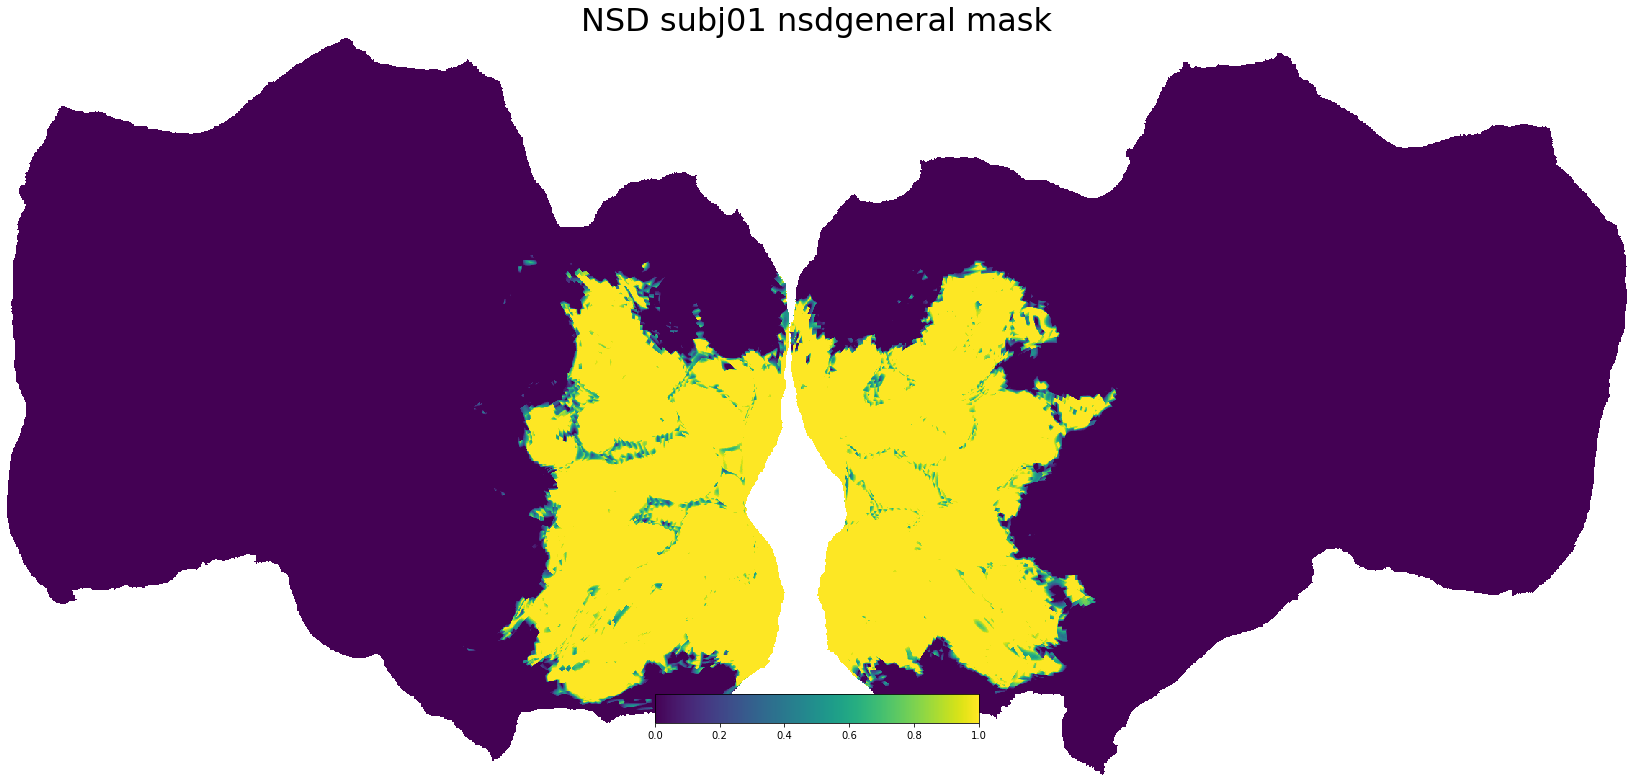

<Figure size 864x576 with 0 Axes>

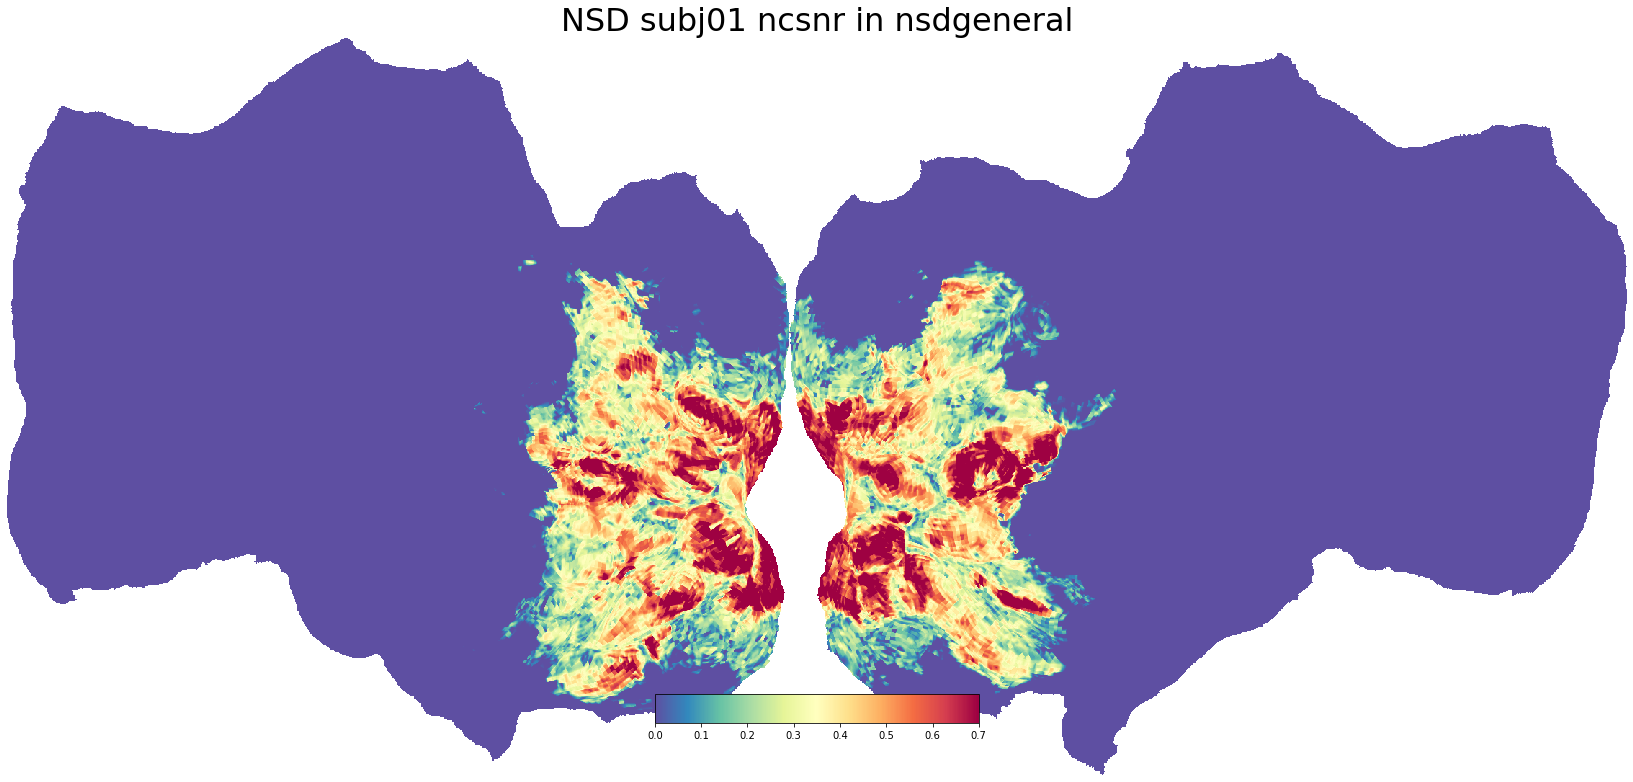

<Figure size 864x576 with 0 Axes>

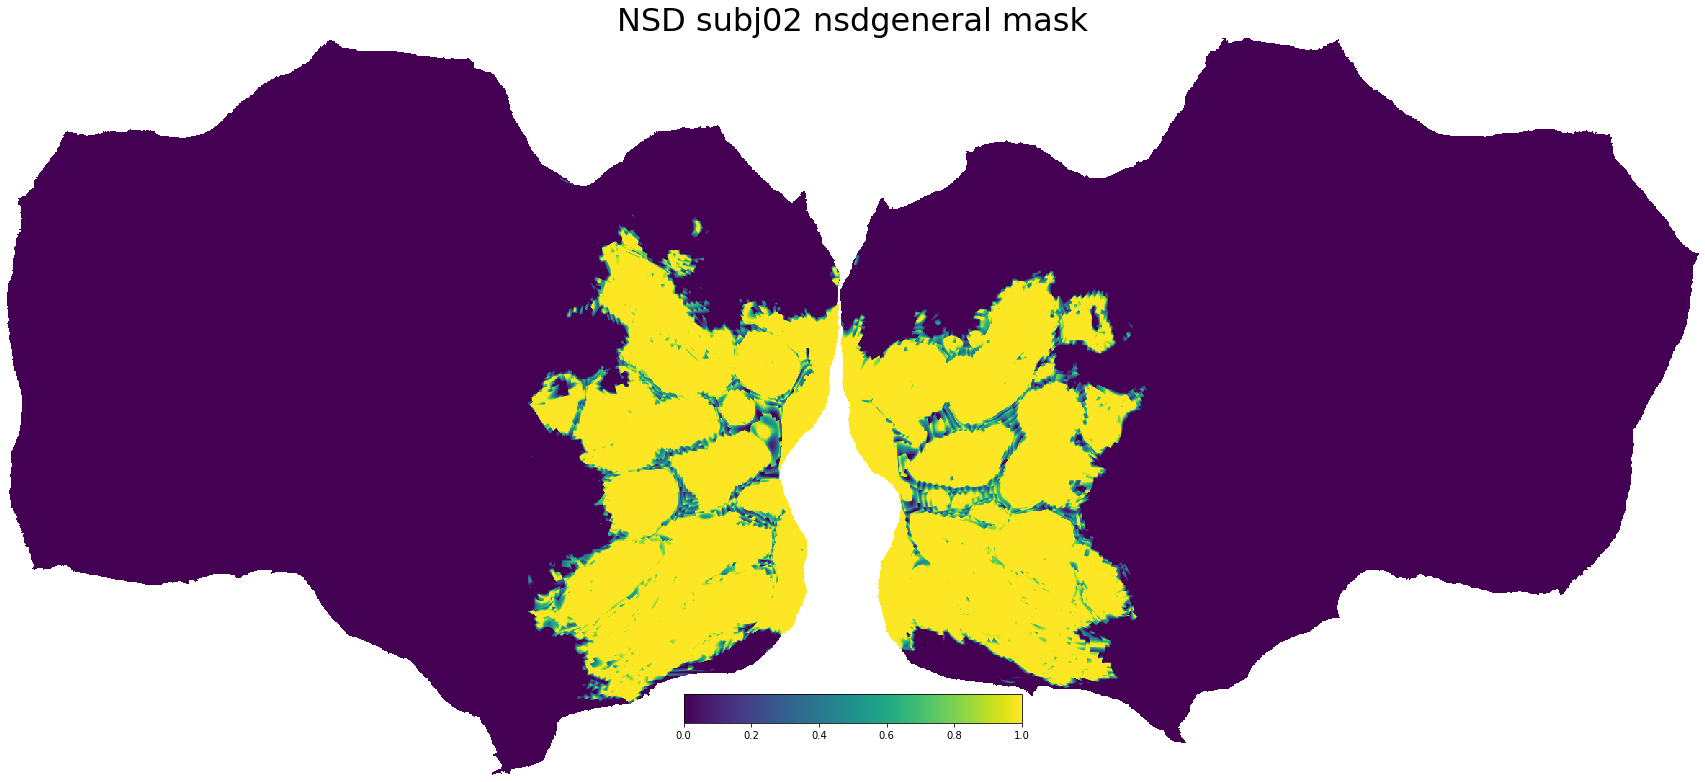

<Figure size 864x576 with 0 Axes>

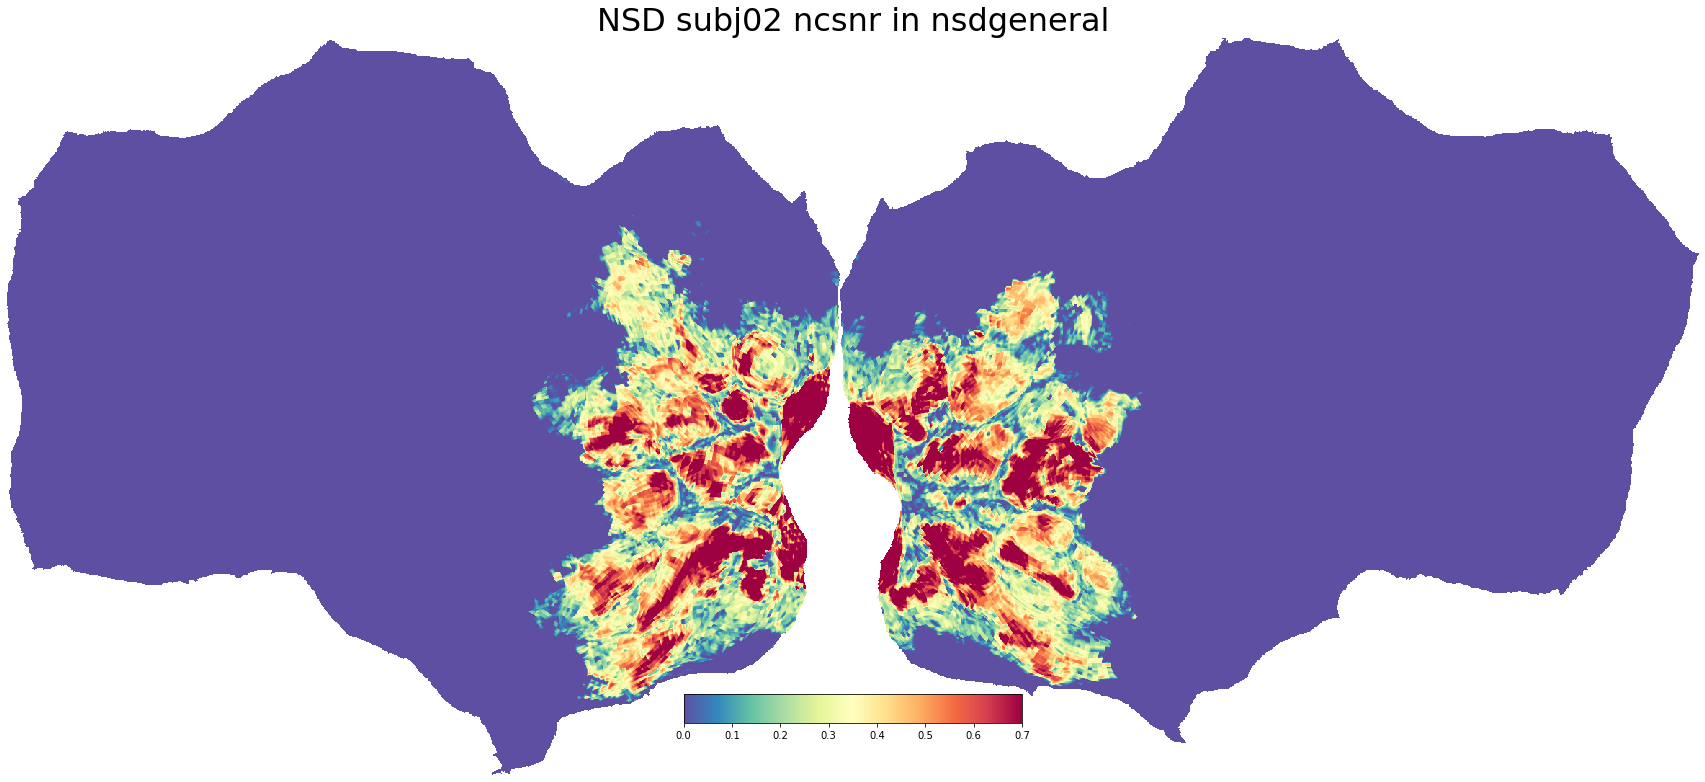

<Figure size 864x576 with 0 Axes>

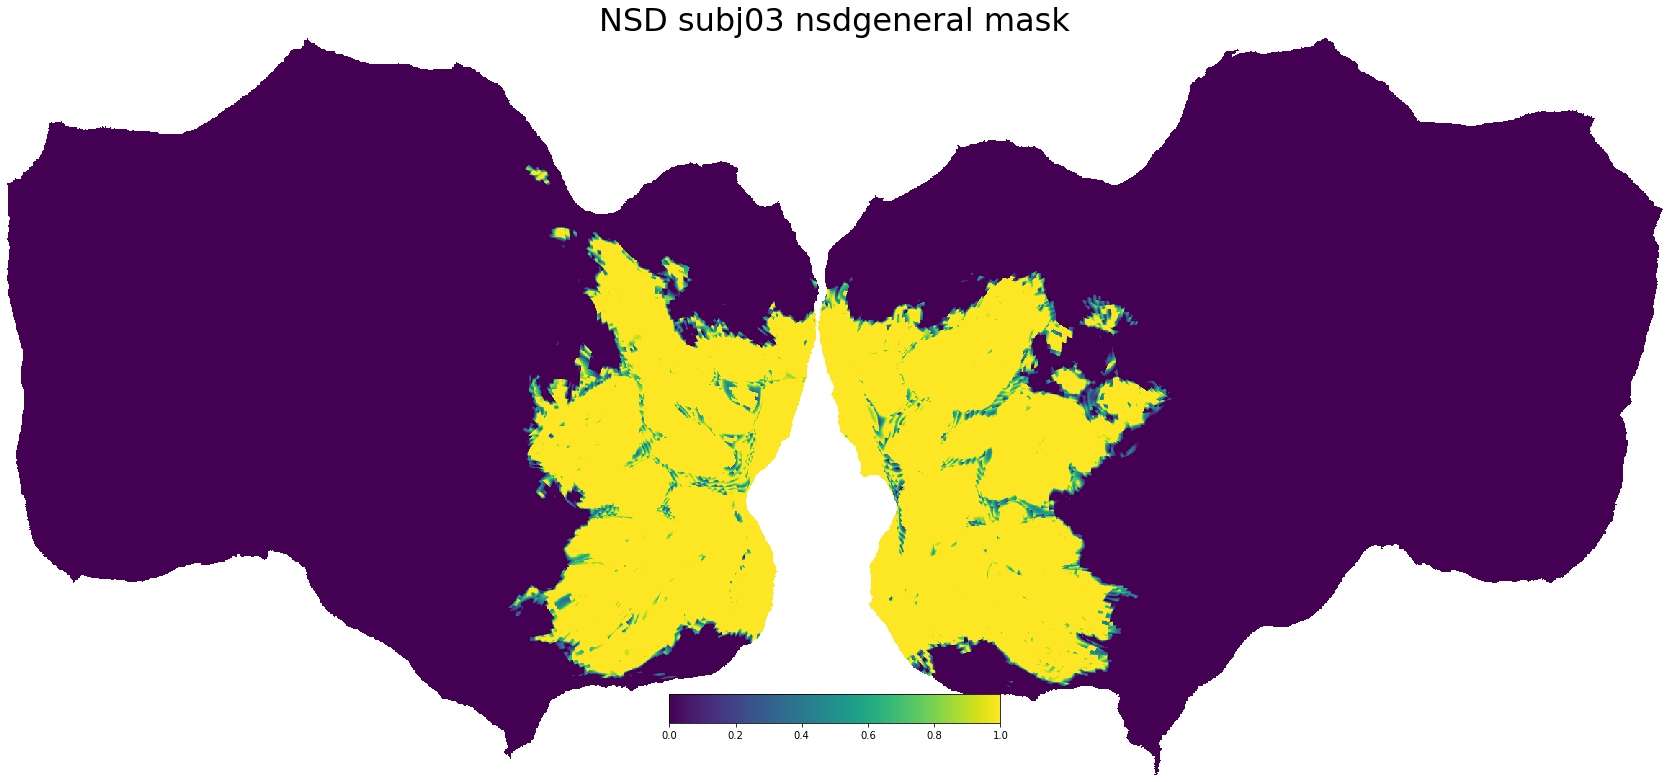

<Figure size 864x576 with 0 Axes>

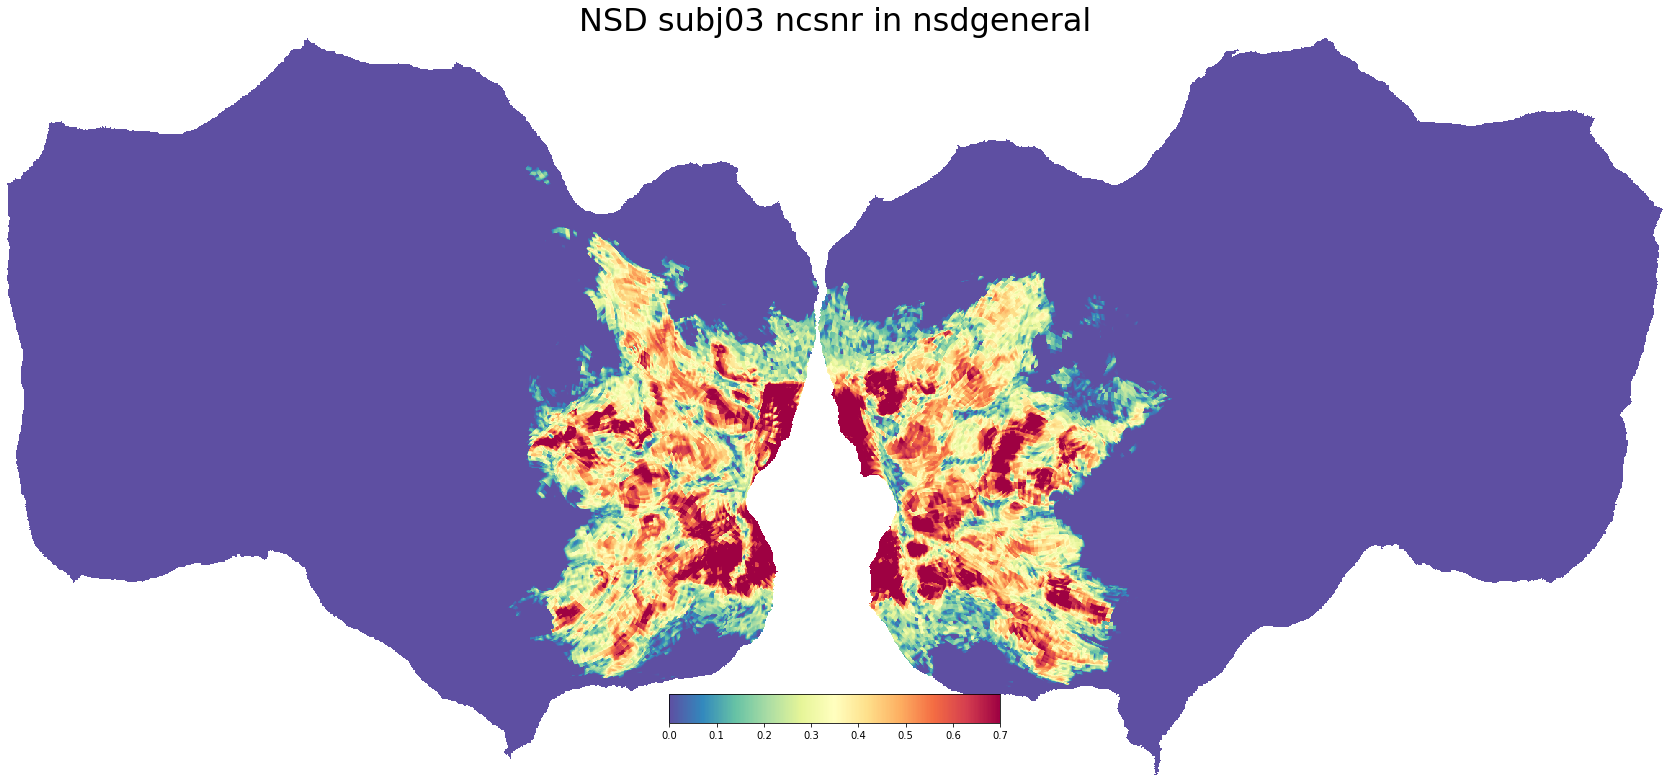

<Figure size 864x576 with 0 Axes>

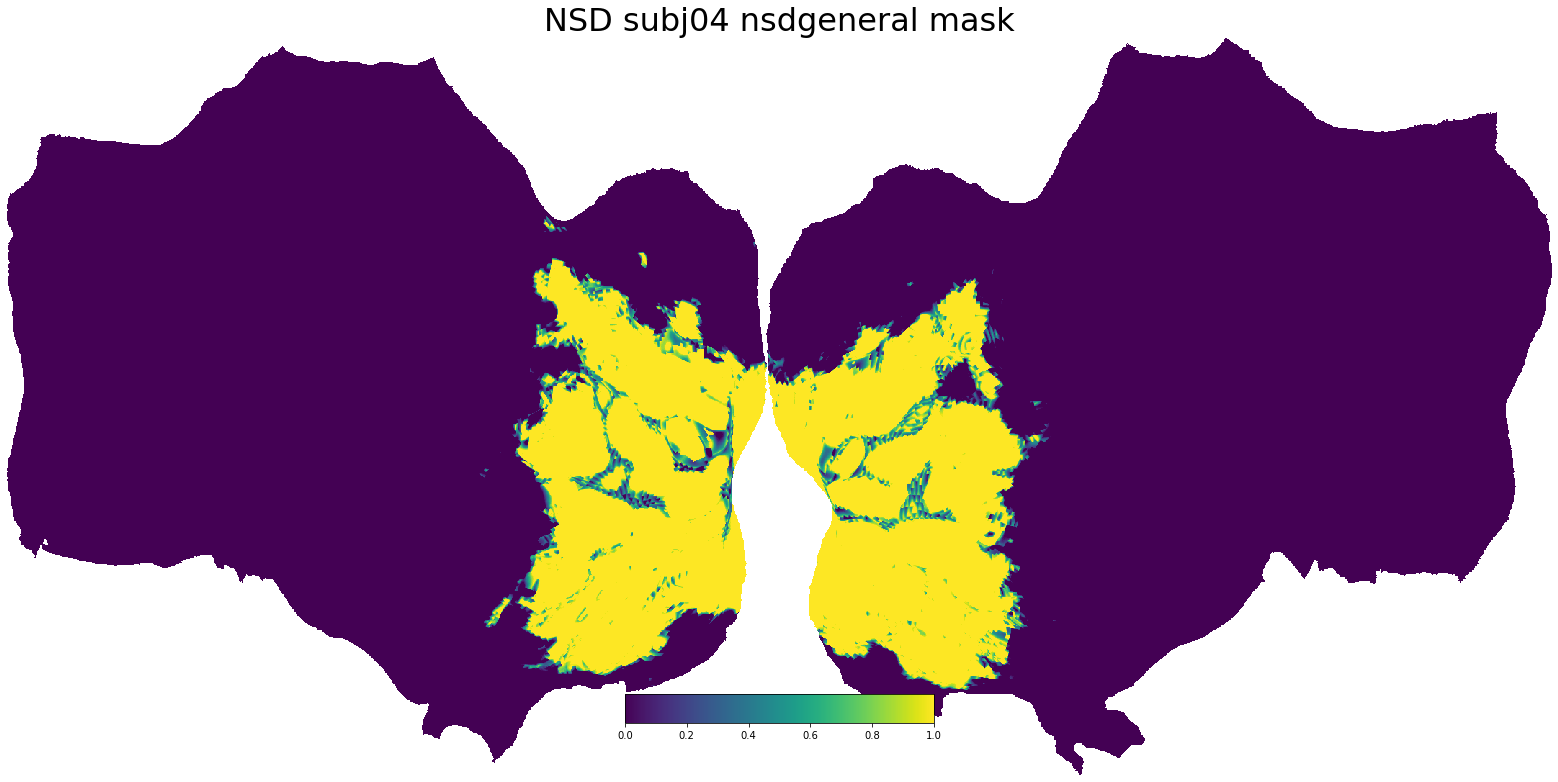

<Figure size 864x576 with 0 Axes>

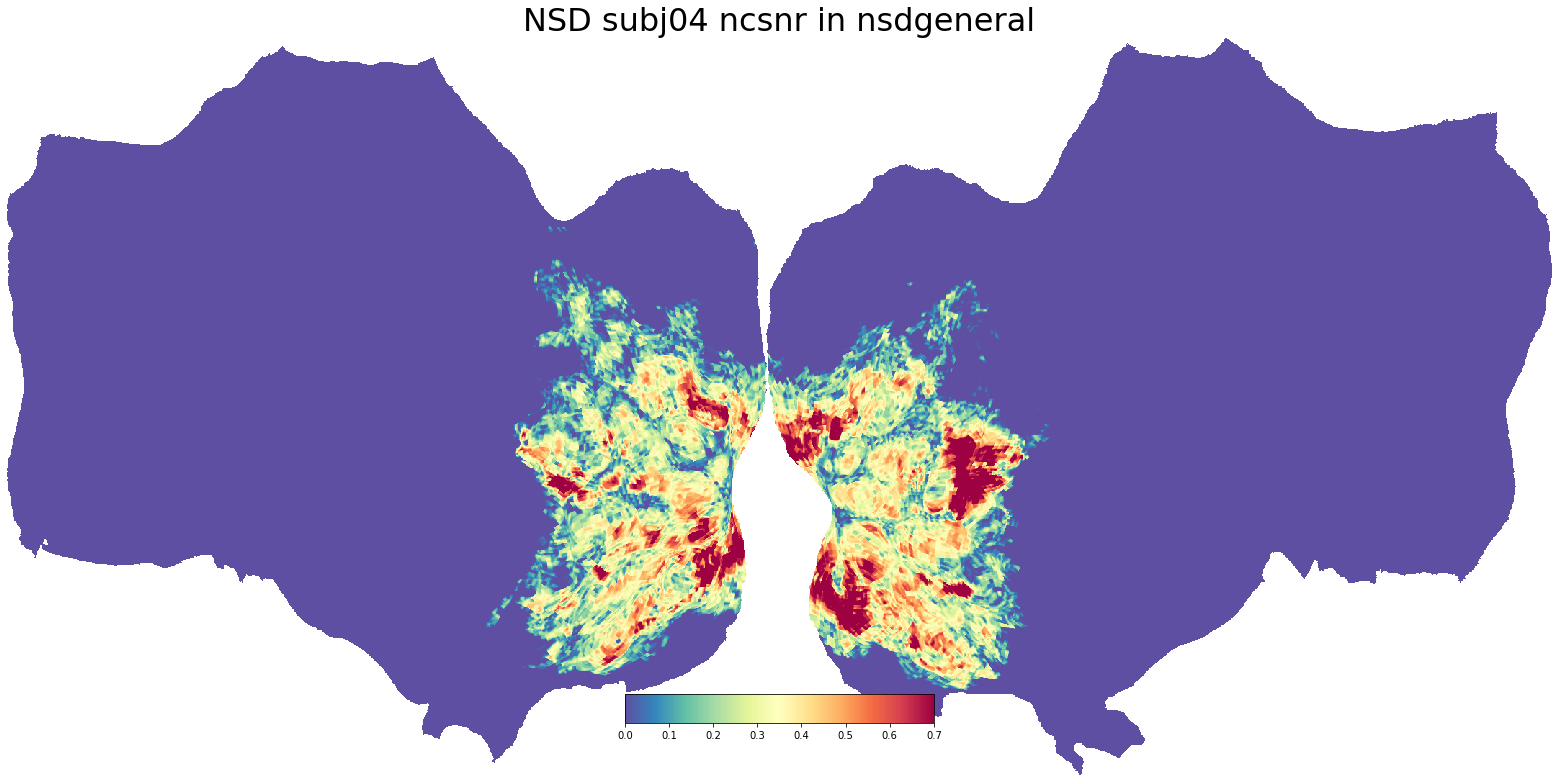

<Figure size 864x576 with 0 Axes>

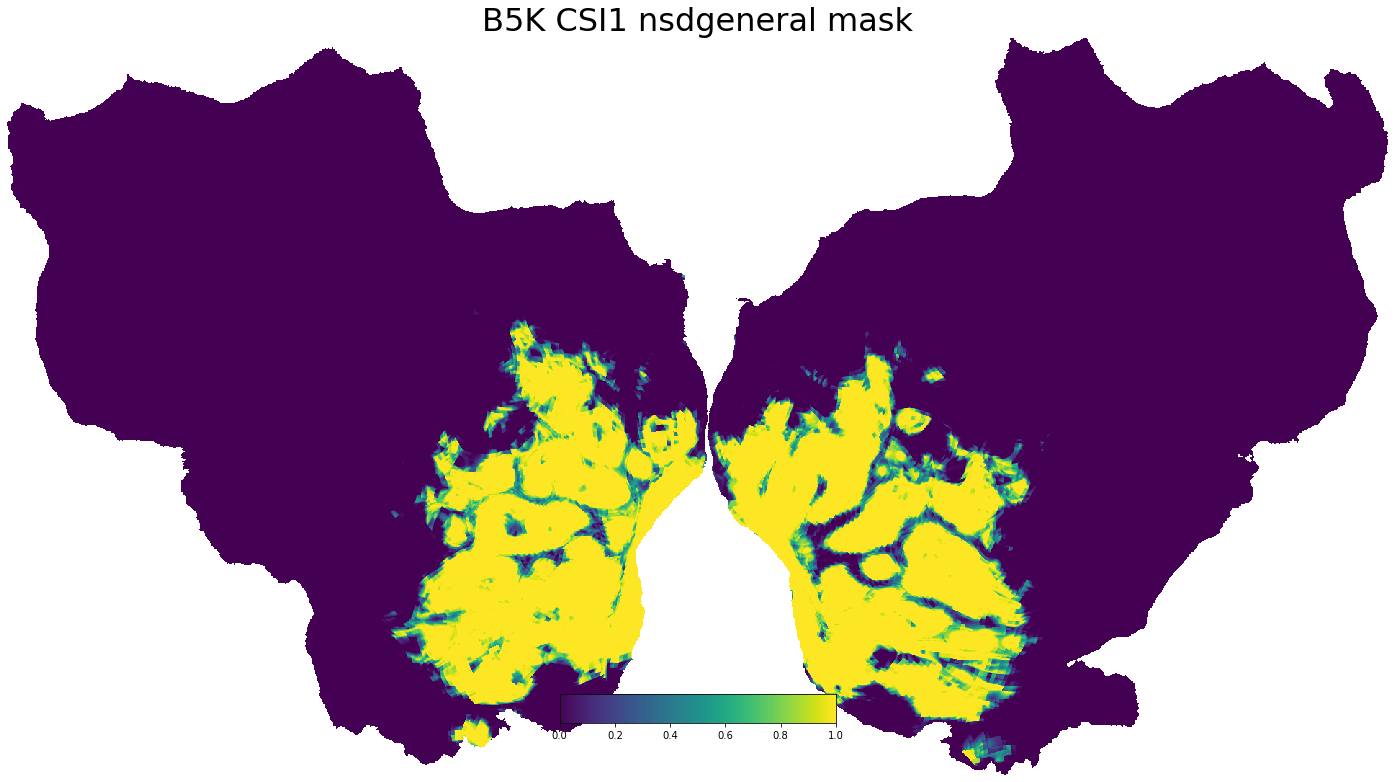

<Figure size 864x576 with 0 Axes>

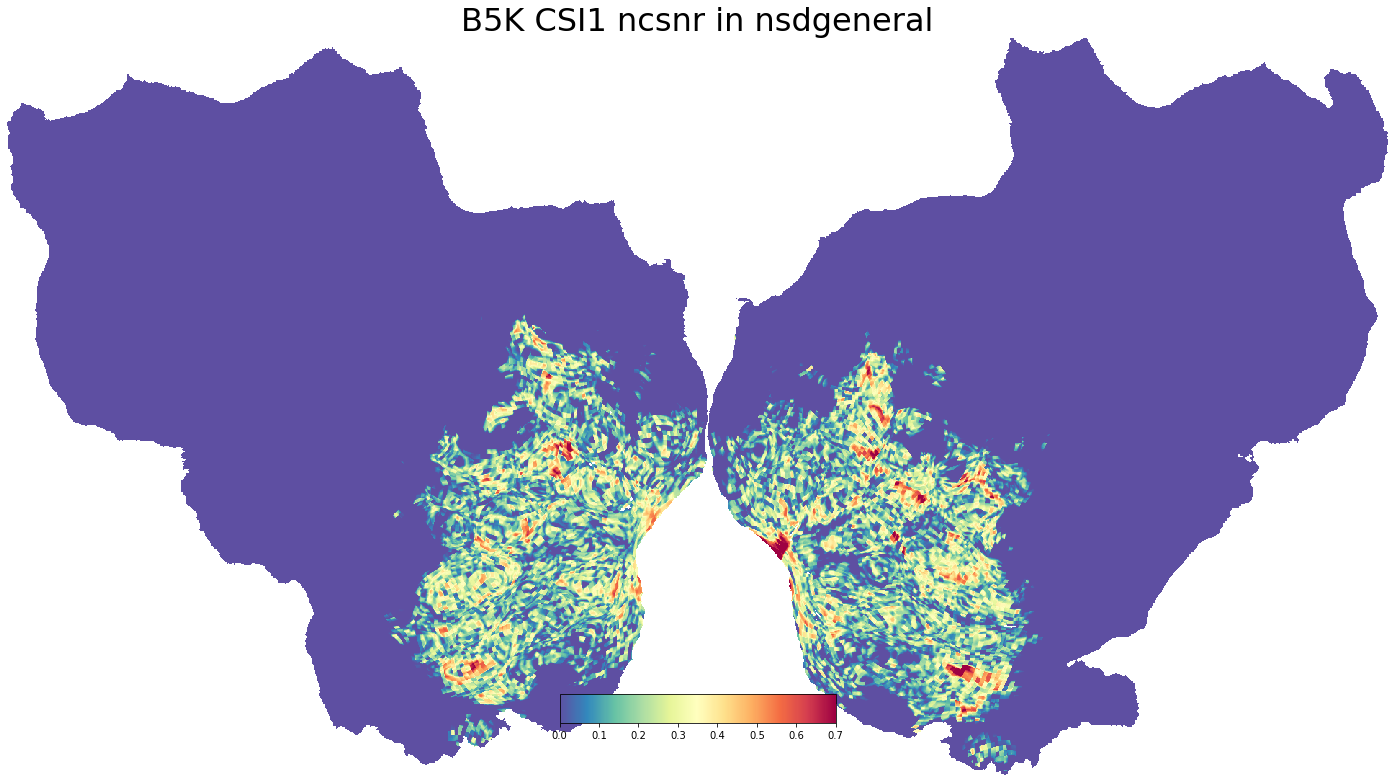

<Figure size 864x576 with 0 Axes>

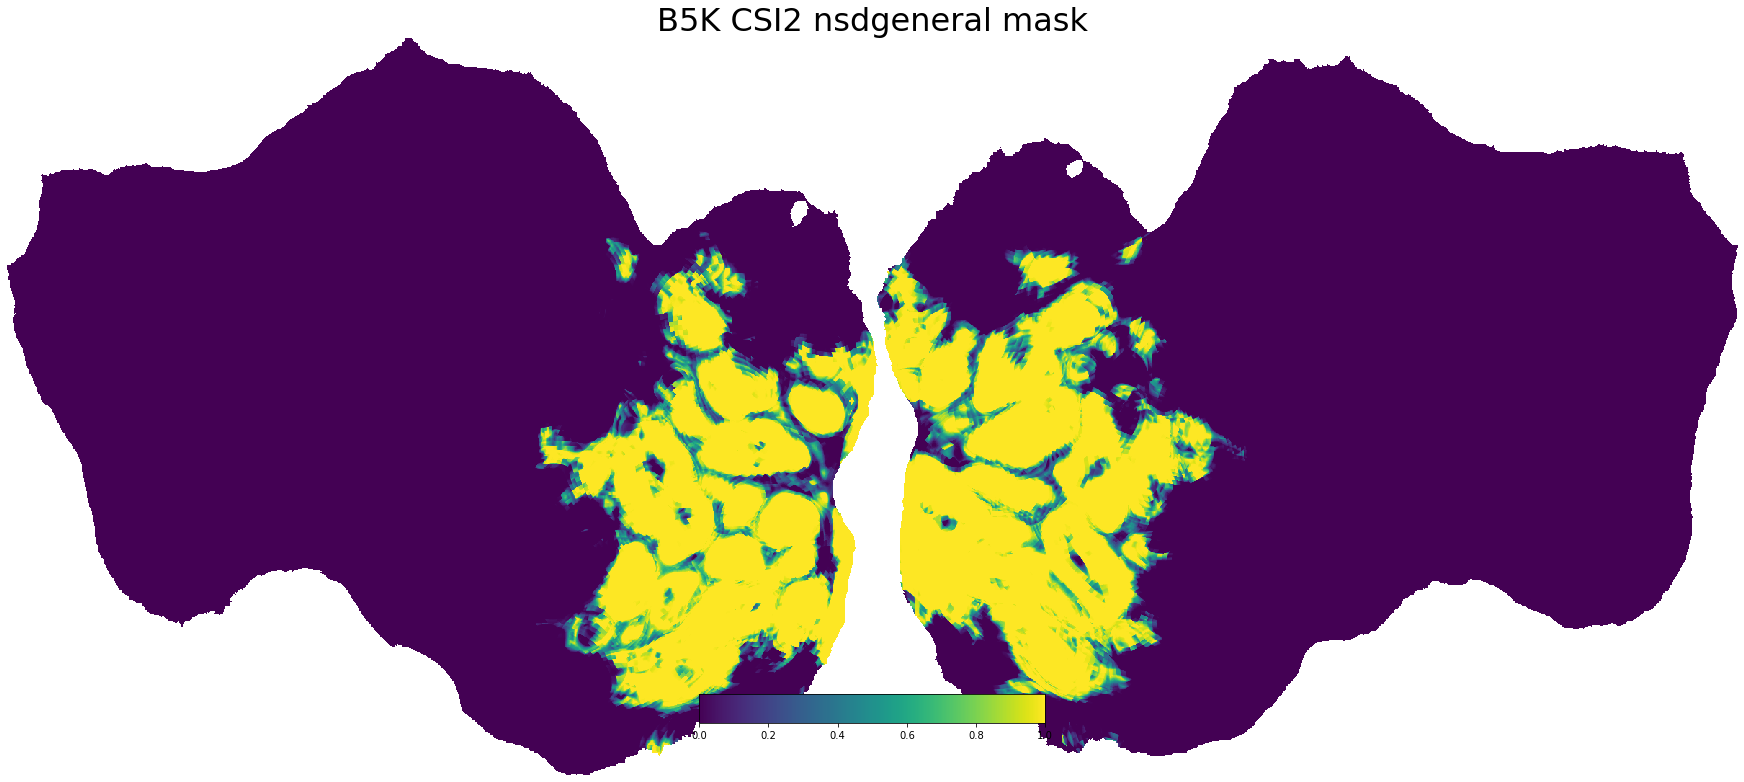

<Figure size 864x576 with 0 Axes>

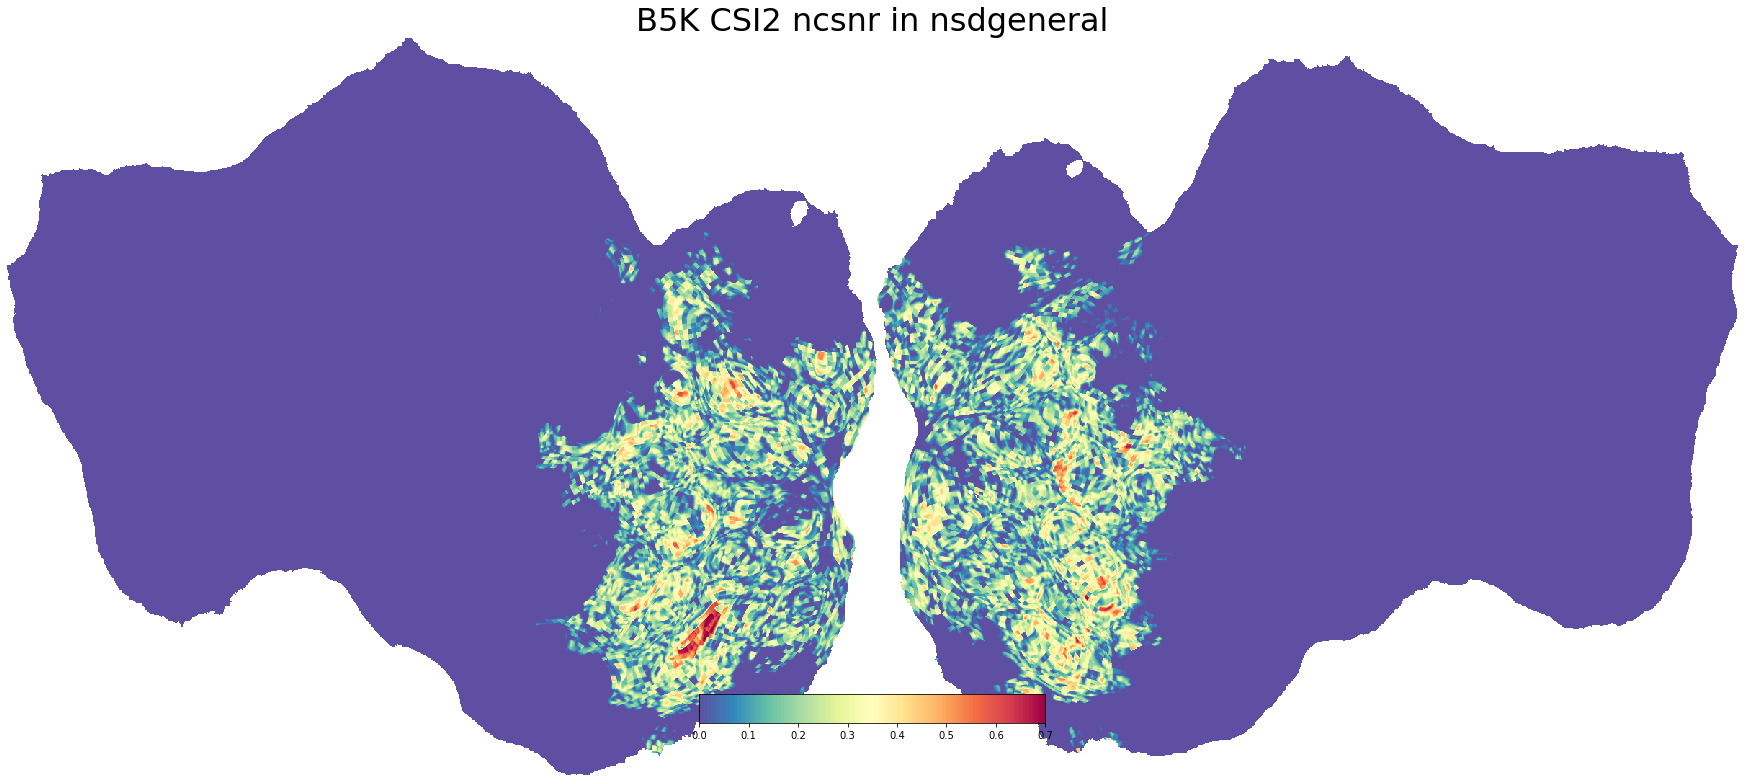

<Figure size 864x576 with 0 Axes>

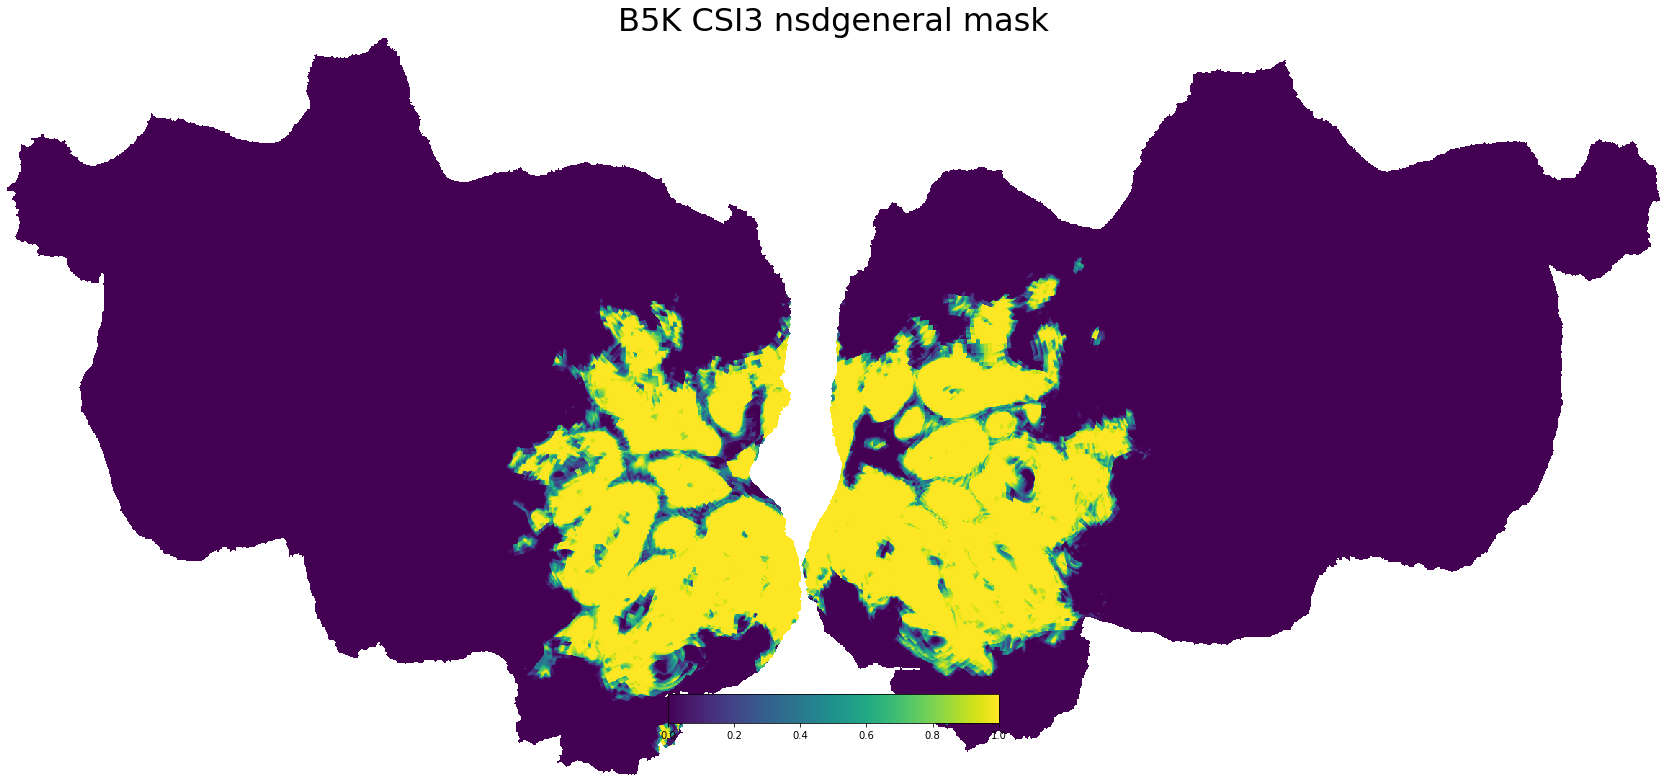

<Figure size 864x576 with 0 Axes>

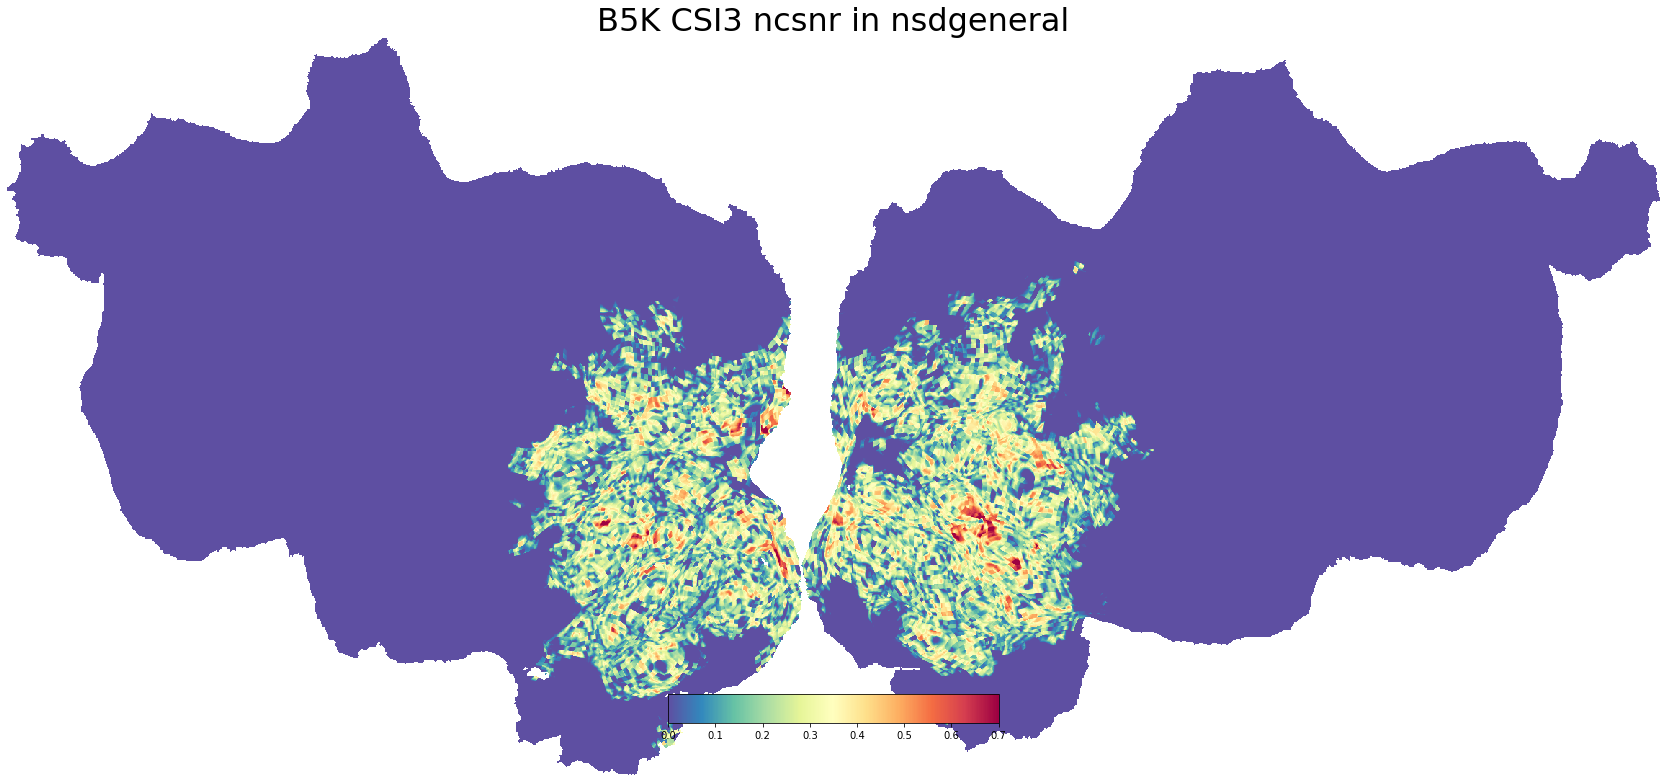

In [35]:
plot_version = 'TYPED_FITHRF_GLMDENOISE_RR'
plot_metric = 'ncsnr'

cortex_data = dict()

lims = dict()
if plot_metric == 'reliability':
    lims['NSD'] = [0,0.3]
    lims['B5K'] = [0,0.3]
elif plot_metric == 'ncpct':
    lims['NSD'] = [0,80]
    lims['B5K'] = [0,65]
elif plot_metric == 'ncsnr':
    lims['NSD'] = [0,0.7]
    lims['B5K'] = [0,0.7]
    
# iterate through datasets
for ds in datasets:
        
    subj_version_means = []
    subj_version_stds = []
        
    # iterate through subjects
    for subj in opts[ds]['subjs']:
        
        if subj == 'CSI4':
            # no cortex data for this subj yet
            continue
        
        maskfn = join(maskdir,f'{subj}_nsdgeneral.nii.gz')
        mask = nib.load(maskfn).get_data()
               
        this_version = copy.deepcopy(X[ds][subj][plot_metric][plot_version])
        this_version[mask == 0] = 0
            
        if ds == 'B5K':
            subj_ = f'sub-{subj}'
        else:
            subj_ = subj
        
        cortex_data[f'{ds} {subj} mask'] = plot_flat_map(ds,subj_,mask,'viridis',0,1)
        plt.title(f'{ds} {subj} nsdgeneral mask',fontsize=ft*2)
        plt.show()

        cortex_data[f'{ds} {subj} {plot_metric}'] = plot_flat_map(ds,subj_,this_version,'Spectral_r',lims[ds][0],lims[ds][1])
        plt.title(f'{ds} {subj} {plot_metric} in nsdgeneral',fontsize=ft*2)
        plt.show()
        